In [1]:
# Load split

import pickle

badIDs = [605515760919, 601983541597]

with open('../../Splits/RegressionAllTasks/split3.bin', 'rb') as f:
    d = pickle.load(f)
    train = []
    trainDirty = d['train']
    test = []
    testDirty = d['test']
    
    # Remove bad subjects
    for subj in trainDirty:
        if subj['ID'] not in badIDs:
            train.append(subj)
            
    for subj in testDirty:
        if subj['ID'] not in badIDs:
            test.append(subj)
    
print(len(train))
print(len(test))
print(train[0])

467
155
{'meta': {'AgeInMonths': 110, 'Gender': 'M', 'Ethnicity': 'AFRICAN', 'AgeGroupID': 1, 'AgeGroupEdge1': 103, 'AgeGroupEdge2': 144}, 'rest': '765', 'nback': '790', 'emoid': '554', 'ID': 608665596582}


In [2]:
# Load data

def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

train_rest_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]
# train_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]

test_rest_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]
# test_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]

print('Complete')

Complete


In [3]:
import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(train_rest_ts)
# normalizeSubjects(train_nback_ts)
# normalizeSubjects(train_emoid_ts)

normalizeSubjects(test_rest_ts)
# normalizeSubjects(test_nback_ts)
# normalizeSubjects(test_emoid_ts)

print('Complete')

Complete


In [4]:
# Calculare pearson matrices

train_rest_p = np.stack([np.corrcoef(sub) for sub in train_rest_ts])
test_rest_p = np.stack([np.corrcoef(sub) for sub in test_rest_ts])

# train_nback_p = np.stack([np.corrcoef(sub) for sub in train_nback_ts])
# test_nback_p = np.stack([np.corrcoef(sub) for sub in test_nback_ts])

print(train_rest_p[0].shape)
print('Complete')

(264, 264)
Complete


In [48]:
roiMap1 = np.zeros(265,dtype='int')
roiMap2 = np.zeros(265,dtype='int')
revMap2 = np.zeros(264,dtype='int')
roiNames = {}
borders1 = []
borders2 = []

with open('../../PP264_template.csv', 'r') as f:
    lines = f.readlines()
    for i in range(2,len(lines)):
        line = lines[i].split(',')
        area = int(line[11])
        r1 = int(line[0])
        r2 = int(line[1])
        name = line[14].strip()
        roiMap1[r1] = area
        roiMap2[r2] = area
        roiNames[area] = name
        revMap2[r1-1] = r2-1
#         print([area, r1, r2, name])

last1 = roiMap1[1]
last2 = roiMap2[1]
for i in range(2,265):
    if roiMap1[i] != last1:
        borders1.append(i)
        last1 = roiMap1[i]
    if roiMap2[i] != last2:
        borders2.append(i)
        last2 = roiMap2[i]
        
print(borders1)
print(borders2)

[31, 36, 50, 63, 121, 126, 157, 182, 200, 213, 222, 233, 237]
[13, 42, 47, 61, 74, 84, 86, 132, 133, 137, 138, 139, 140, 143, 174, 182, 186, 203, 221, 222, 235, 243, 247, 251, 253, 255, 256]


In [49]:
def rearrange(p, idcs):
    idcsp = idcs[1:]
    return p[:,idcsp][idcsp]

rearrange(train_rest_p[0], revMap2)

array([[ 1.        ,  0.62105487,  0.44993324, ...,  0.11666982,
         0.43220666,  0.50979494],
       [ 0.62105487,  1.        ,  0.48584035, ...,  0.08403637,
         0.64354739,  0.56825486],
       [ 0.44993324,  0.48584035,  1.        , ...,  0.10386397,
         0.30758608,  0.24113653],
       ...,
       [ 0.11666982,  0.08403637,  0.10386397, ...,  1.        ,
        -0.09356876, -0.19613618],
       [ 0.43220666,  0.64354739,  0.30758608, ..., -0.09356876,
         1.        ,  0.59740386],
       [ 0.50979494,  0.56825486,  0.24113653, ..., -0.19613618,
         0.59740386,  1.        ]])

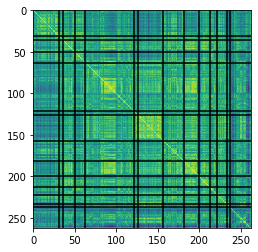

In [51]:
import matplotlib.pyplot as plt

plt.imshow(rearrange(train_rest_p[0], revMap2))
for b in borders1:
    plt.plot([0,263],[b,b],color='black')
    plt.plot([b,b],[0,263],color='black')
plt.xlim(0,263)
plt.ylim(262,0)
plt.show()